In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib as plt
import bokeh
from bokeh.plotting import figure, output_file, show

In [3]:
# Uses connection to create a table of values from the sqlite table through pandas 
import sqlite3

conn = sqlite3.connect("/Volumes/Amogh_USB/ants_work/ants.db")  # Full Mac path hardcoded
df_orig = pd.read_sql_query("select * from ants;", conn)
# df_orig.sample(10)
# df_orig.describe()

In [4]:
# Perform imputation and more
from scipy.stats import mode
df = df_orig.copy(deep=True)  

df['ants_count'].fillna(mode(df['ants_count']).mode[0], inplace=True)  # Replace NaN with with mode
df['ants_count'] = df['ants_count'].astype(int)                        # Convert float to int
# df_orig.sample(10)
#df['ants_count'].groupby(df['solution']).describe()
df

,solution,image,ants_count
0,control,/home/pi/ant_images/control/20190303_103835.jpeg,3
1,control,/home/pi/ant_images/control/20190303_103934.jpeg,6
2,control,/home/pi/ant_images/control/20190303_104034.jpeg,5
3,control,/home/pi/ant_images/control/20190303_104135.jpeg,8
4,control,/home/pi/ant_images/control/20190303_104236.jpeg,6
5,control,/home/pi/ant_images/control/20190303_104337.jpeg,9
6,control,/home/pi/ant_images/control/20190303_104437.jpeg,10
7,control,/home/pi/ant_images/control/20190303_104538.jpeg,9
8,control,/home/pi/ant_images/control/20190303_104639.jpeg,6
9,control,/home/pi/ant_images/control/20190303_104740.jpeg,8


In [5]:
# Get Minute value from datetime stamp [YYYYmmDD_HHMMSS.jpeg].  
#  Experiements were all run on the same day and hence date can be ignored.
#  Sample image file: /home/pi/ant_images/<solution>/<20190303_121201.jpeg'

import re
pattern = '\d+_(\d{4})\d{2}.jpeg$'  # Get HHMM from YYYYmmDD_(HHMM)SS.jpeg

df['image'] = df['image'].str.replace('/home/pi/ant_images/', '')  # Remove full path of each image
df['minute'] = df['image'].str.extract(pattern,expand=False)
df['minute'] = df['minute'].astype(int)  # convert str to int type


# Find start-time(min value) for each solution and get difference (1 min for each consecutive row)
#  And special handle when hour rolls over with difference of 41 (xx59 to yy00)
df['time_diff'] = df['minute'] - df.groupby('solution')['minute'].transform('min')
df['time_diff_diff'] = df.groupby('solution')['minute'].diff()   # Compare to previous row value. Should be 1 or 41
df['time_diff_diff_1min'] = np.where(df['time_diff_diff'] == 41, df['time_diff_diff'] - 40, df['time_diff_diff'])

# Now create cumulative sum for each group
df['x_coord'] = df.groupby(['solution'])['time_diff_diff_1min'].apply(lambda x: x.cumsum())
# df

# Set NaN (first row value of diffs) to 0 x-coordinate
df['x_coord'] = np.where(df['x_coord'].isnull(), 0.0, df['x_coord'])
# print(df.to_string())

df['ants_count'].groupby(df['solution']).describe()

,count,mean,std,min,25%,50%,75%,max
solution,,,,,,,,
banana,30.0,22.966667,3.846031,14.0,21.00,23.0,25.75,29.0
cayenne,29.0,19.827586,5.471151,11.0,15.00,20.0,23.00,30.0
cinnamon,27.0,4.259259,2.725839,0.0,2.00,4.0,5.50,10.0
control,31.0,4.580645,2.941362,0.0,2.00,4.0,7.00,10.0
lime,43.0,17.372093,4.670185,3.0,14.00,18.0,21.00,27.0
lime_spray,40.0,15.550000,2.782270,7.0,13.75,15.5,17.00,21.0
peppermint,29.0,19.275862,4.697237,9.0,16.00,18.0,23.00,29.0
vinegar,40.0,3.725000,2.764125,1.0,2.00,3.0,5.00,15.0


In [6]:
# Some data cleanup (Sample size, banana count adjust)
# Make 30 samples for lime, lime_spray and vinegar

# df[df['solution'] == 'lime_spray']  # To get minute values of rows to delete
# df[(df.solution == 'lime') & (df.minute > 1333)]

df.loc[df['solution'] == 'banana', ['ants_count']] += 5

df.drop(df[(df.solution == 'lime')       & (df.minute > 1333)].index, inplace=True)
df.drop(df[(df.solution == 'lime_spray') & (df.minute > 1435)].index, inplace=True)
df.drop(df[(df.solution == 'vinegar')    & (df.minute > 1750)].index, inplace=True)

df['ants_count'].groupby(df['solution']).describe()

,count,mean,std,min,25%,50%,75%,max
solution,,,,,,,,
banana,30.0,27.966667,3.846031,19.0,26.0,28.0,30.75,34.0
cayenne,29.0,19.827586,5.471151,11.0,15.0,20.0,23.00,30.0
cinnamon,27.0,4.259259,2.725839,0.0,2.0,4.0,5.50,10.0
control,31.0,4.580645,2.941362,0.0,2.0,4.0,7.00,10.0
lime,30.0,18.933333,4.645601,3.0,16.5,20.0,22.00,27.0
lime_spray,30.0,14.966667,2.709922,7.0,13.0,15.0,16.00,21.0
peppermint,29.0,19.275862,4.697237,9.0,16.0,18.0,23.00,29.0
vinegar,30.0,4.033333,3.090400,1.0,2.0,4.0,5.00,15.0


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

color = {'boxes': 'DarkGreen', 
         'whiskers': 'DarkOrange',
         'medians': 'DarkBlue', 
         'caps': 'Gray'}
plt.rcParams["figure.figsize"] = [15, 9]
# plt.title('Histogram of Counts of Ants Near Food with Repellents')
# df.boxplot(column="ants_count", by="solution")

solution
banana        28
cayenne       20
cinnamon       4
control        4
lime          20
lime_spray    15
peppermint    18
vinegar        4
Name: ants_count, dtype: int64


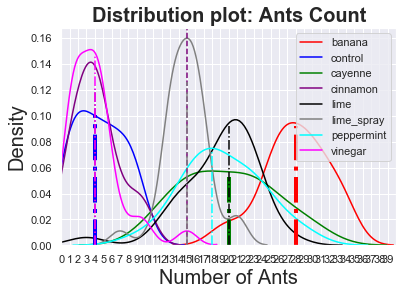

In [8]:
# Seaborn distplot by default will uses a kernel density estimate (KDE)
# Ref: https://en.wikipedia.org/wiki/Kernel_density_estimation
# KDE probability density function of a random variable and KDE estimation is a fundamental data smoothing problem 
# where inferences about the population are made, based on a finite data sample

import seaborn as sns
sns.set(color_codes=True)

# Create a plot
fig, ax = plt.subplots()

target_0 = df.loc[df['solution'] == 'banana']
target_1 = df.loc[df['solution'] == 'control']
target_2 = df.loc[df['solution'] == 'cayenne']
target_3 = df.loc[df['solution'] == 'cinnamon']
target_4 = df.loc[df['solution'] == 'lime']
target_5 = df.loc[df['solution'] == 'lime_spray']
target_6 = df.loc[df['solution'] == 'peppermint']
target_7 = df.loc[df['solution'] == 'vinegar']

# Create distplot for each solution
sns.distplot(target_0['ants_count'], label='banana',  hist=False, color='red')
sns.distplot(target_1['ants_count'], label='control', hist=False, color='blue')
sns.distplot(target_2['ants_count'], label='cayenne', hist=False, color='green')
sns.distplot(target_3['ants_count'], label='cinnamon', hist=False,color='purple')
sns.distplot(target_4['ants_count'], label='lime',     hist=False,    color='black')
sns.distplot(target_5['ants_count'], label='lime_spray', hist=False, color='gray')
sns.distplot(target_6['ants_count'], label='peppermint', hist=False, color='cyan')
sns.distplot(target_7['ants_count'], label='vinegar', hist=False, color='magenta')

# Add labels and title
ax.set_xlim(0,40) # We have 0 to 40 mins range
ax.set_xticks(range(0,40))
# ax.set(xlabel='Number of Ants', ylabel='Density')
ax.set_title('Distribution plot: Ants Count', fontweight="bold", size=20) # Title
ax.set_ylabel('Density', fontsize = 20) # Y label
ax.set_xlabel('Number of Ants', fontsize = 20)

# Get median of all set...
full_median = df['ants_count'].agg('median')
plt.axvline(full_median, 0, 1, color='#770077', linestyle='--')

# Get Median of each solution
df_medians = df.groupby('solution')['ants_count'].agg('median')
plt.axvline(df_medians['banana'],  0, 0.55,   color='red',   linestyle='dashdot', linewidth=4)
plt.axvline(df_medians['control'], 0, 0.60,   color='blue',  linestyle='dashdot', linewidth=4)
plt.axvline(df_medians['cayenne'], 0, 0.32,    color='green', linestyle='dashdot', linewidth=4)
plt.axvline(df_medians['cinnamon'],0, 0.72,   color='purple',linestyle='dashdot')
plt.axvline(df_medians['lime'],    0, 0.55,   color='black', linestyle='dashdot')
plt.axvline(df_medians['lime_spray'], 0, 0.75,color='gray',  linestyle='dashdot')
plt.axvline(df_medians['peppermint'], 0, 0.44,color='cyan',linestyle='dashdot')
plt.axvline(df_medians['vinegar'],    0, 0.87,color='magenta',linestyle='dashdot')

# Display final plot
# plt.show()
print(df_medians)

In [9]:
df_pt = df.pivot(index='x_coord', columns='solution', values='ants_count')
plt = df_pt.plot()
# plt.set_xlabel('Minutes', fontsize=20)
# plt.set_ylabel('Ants Count', fontsize=20)

In [10]:
# --- Helpful debugging statements...
# df[df['ants_count'].isnull()]  # Get rows that have NaN in them
# df[201] & df[231] have NaN for count
# df['ants_count'].fillna(0)

# df[df['solution'] == 'banana']                     # Display only "Lime" solution rows
# df[(df.solution == 'lime') & (df.minute > 1334)] # Multiple conditions
# df['time_diff'] = df.groupby('solution')['minute'].diff()  # find one diff with next row i.e. 1 min except when next hour
# Whereever there is diff of 41 due to hhmm rolling to next hour change it to 1.


In [12]:
# Debug: sqlite3 database - Connection is created between sqlite table and program, prints the table 
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

def select_task(conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM ants")
 
    rows = cur.fetchall()
    # print and check database data
    # for r in rows: print(r)  # DEBUG
    return None

if __name__ == '__main__':
    database = "/Volumes/Amogh_USB/ants_work/ants.db"
    conn = create_connection(database)
    select_task(conn)